In [1]:
%cd C:\mimic-iv-2.2\mimic-iv-2.2\hosp

C:\mimic-iv-2.2\mimic-iv-2.2\hosp


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 파일간 병합 및 전처리

## d_icd_diagnoses파일 

In [3]:
df_d_icd_diagnoses = pd.read_csv('d_icd_diagnoses.csv')
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int64 
 2   long_title   109775 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [4]:
for i in df_d_icd_diagnoses.columns:
    print(i,df_d_icd_diagnoses[i].min(),df_d_icd_diagnoses[i].max())

icd_code 0010 Z9989
icd_version 9 10
long_title "Light-for-dates" with signs of fetal malnutrition, 1,000-1,249 grams von Gierke disease


In [5]:
# int32를 int16으로 변환
df_d_icd_diagnoses['icd_version'] = df_d_icd_diagnoses['icd_version'].astype('int16')
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int16 
 2   long_title   109775 non-null  object
dtypes: int16(1), object(2)
memory usage: 1.9+ MB


In [6]:
df_d_icd_diagnoses.drop(['icd_version','long_title'],axis=1,inplace =True)
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   icd_code  109775 non-null  object
dtypes: object(1)
memory usage: 857.7+ KB


## diagnoses_icd파일

In [7]:
df_diagnoses_icd = pd.read_csv("diagnoses_icd.csv")
df_diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


## 고혈압이면서 암걸린 환자들만 추출

In [8]:
# 고혈압 진단 코드 정규식
high_bp_regex = r'^I1[0-5]$|^401'

#암 진단 코드 정규식  
#ICD-9 코드 분류 (140-239)
#ICD-10 코드 분류 (C00-C96, D00-D09)
cancer_regex = r'^(D(0[0-9])|C([0-8][0-9]|9[0-6])|(1[4-9][0-9]|2[0-3][0-9])).*'


# 암 진단 코드 추출
cancer_df = df_diagnoses_icd[df_diagnoses_icd['icd_code'].str.match(cancer_regex)]

# 암 진단을 받은 환자 ID 추출
cancer_patient_ids = cancer_df['subject_id'].unique()

# 암 진단을 받은 환자들의 데이터 추출 
#병합
cancer_diagnoses_merged = pd.merge(df_diagnoses_icd, df_d_icd_diagnoses, on=['icd_code'])
cancer_patients_data = cancer_diagnoses_merged[cancer_diagnoses_merged['subject_id'].isin(cancer_patient_ids)]



# 암 및 고혈압을 동시에 가진 환자들의 데이터 추출 (첫 번째 진단만 포함)
cancer_high_bp_ids = cancer_patients_data[cancer_patients_data['icd_code'].str.match(high_bp_regex)]['subject_id'].unique()
cancer_high_bp_df = cancer_diagnoses_merged[(cancer_diagnoses_merged['subject_id'].isin(cancer_high_bp_ids)) & 
                                            (cancer_diagnoses_merged['seq_num'] == 1) & 
                                            (cancer_diagnoses_merged['icd_code'].str.match(cancer_regex))]

cancer_high_bp_df

,subject_id,hadm_id,seq_num,icd_code,icd_version
393337,10071129,25200387,1,1890,9
393339,10094971,20200109,1,1890,9
393351,10171405,23985269,1,1890,9
393356,10171405,29677692,1,1890,9
393364,10322775,24742385,1,1890,9
...,...,...,...,...,...
4859732,19128927,28814179,1,C44692,10
4859827,19282415,28695316,1,C004,10
4859828,19290501,28187167,1,C8468,10
4860174,19851929,29152819,1,1643,9


In [9]:
cancer_high_bp_df.drop(['icd_version','seq_num'],axis=1, inplace=True)

C:\Users\TS\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
cancer_high_bp_df.reset_index()

,index,subject_id,hadm_id,icd_code
0,393337,10071129,25200387,1890
1,393339,10094971,20200109,1890
2,393351,10171405,23985269,1890
3,393356,10171405,29677692,1890
4,393364,10322775,24742385,1890
...,...,...,...,...
13238,4859732,19128927,28814179,C44692
13239,4859827,19282415,28695316,C004
13240,4859828,19290501,28187167,C8468
13241,4860174,19851929,29152819,1643


In [11]:
cancer_high_bp_df

,subject_id,hadm_id,icd_code
393337,10071129,25200387,1890
393339,10094971,20200109,1890
393351,10171405,23985269,1890
393356,10171405,29677692,1890
393364,10322775,24742385,1890
...,...,...,...
4859732,19128927,28814179,C44692
4859827,19282415,28695316,C004
4859828,19290501,28187167,C8468
4860174,19851929,29152819,1643


In [12]:
cancer_high_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13243 entries, 393337 to 4860191
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  13243 non-null  int64 
 1   hadm_id     13243 non-null  int64 
 2   icd_code    13243 non-null  object
dtypes: int64(2), object(1)
memory usage: 413.8+ KB


In [13]:
for i in cancer_high_bp_df.columns:
    print(i,cancer_high_bp_df[i].min(),cancer_high_bp_df[i].max())

subject_id 10001401 19999784
hadm_id 20000808 29998978
icd_code 1410 D0919


In [14]:
cancer_high_bp_df['subject_id'] = cancer_high_bp_df['subject_id'].astype('int32')
cancer_high_bp_df['hadm_id'] = cancer_high_bp_df['hadm_id'].astype('int32')

C:\Users\TS\AppData\Local\Temp\ipykernel_11152\3501051655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_high_bp_df['subject_id'] = cancer_high_bp_df['subject_id'].astype('int32')
C:\Users\TS\AppData\Local\Temp\ipykernel_11152\3501051655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_high_bp_df['hadm_id'] = cancer_high_bp_df['hadm_id'].astype('int32')


In [15]:
cancer_high_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13243 entries, 393337 to 4860191
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  13243 non-null  int32 
 1   hadm_id     13243 non-null  int32 
 2   icd_code    13243 non-null  object
dtypes: int32(2), object(1)
memory usage: 310.4+ KB


In [16]:
# subject_id로 그룹화하고 각 그룹에서 hadm_id가 가장 작은 행 선택
result = cancer_high_bp_df.loc[cancer_high_bp_df.groupby('subject_id')['hadm_id'].idxmin()]

# 필요시 인덱스 리셋
result.reset_index(drop=True, inplace=True)

In [17]:
result

,subject_id,hadm_id,icd_code
0,10001401,21544441,C675
1,10001877,25679292,2252
2,10002155,20345487,1628
3,10002348,22725460,C7931
4,10003400,20214994,1543
...,...,...,...
9183,19996783,22140408,C259
9184,19997538,22701415,C20
9185,19999204,29046609,C220
9186,19999287,22997012,1629


## patients 파일

In [18]:
df_patients = pd.read_csv("patients.csv")

In [19]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


In [20]:
df_patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


In [21]:
merge2 = pd.merge(result,df_patients, on=['subject_id'])
merge2

,subject_id,hadm_id,icd_code,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10001401,21544441,C675,F,89,2131,2014 - 2016,NaN
1,10001877,25679292,2252,M,89,2149,2008 - 2010,NaN
2,10002155,20345487,1628,F,80,2128,2008 - 2010,2131-03-10
3,10002348,22725460,C7931,F,77,2112,2017 - 2019,NaN
4,10003400,20214994,1543,F,72,2134,2011 - 2013,2137-09-02
...,...,...,...,...,...,...,...,...
9183,19996783,22140408,C259,M,89,2188,2017 - 2019,2188-05-21
9184,19997538,22701415,C20,M,53,2168,2017 - 2019,NaN
9185,19999204,29046609,C220,M,61,2146,2017 - 2019,2146-08-29
9186,19999287,22997012,1629,F,71,2191,2008 - 2010,2197-09-02


## admissions파일

In [22]:
df_admission = pd.read_csv("admissions.csv")
merge2_admission = pd.merge(merge2,df_admission, on=['subject_id','hadm_id'])
merge2_admission

,subject_id,hadm_id,icd_code,gender,anchor_age,anchor_year,anchor_year_group,dod,admittime,dischtime,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,C675,F,89,2131,2014 - 2016,NaN,2131-06-04 00:00:00,2131-06-15 16:10:00,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001877,25679292,2252,M,89,2149,2008 - 2010,NaN,2149-05-21 15:53:00,2149-05-27 13:35:00,...,P47KFL,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2149-05-21 10:58:00,2149-05-21 17:15:00,0
2,10002155,20345487,1628,F,80,2128,2008 - 2010,2131-03-10,2131-03-09 20:33:00,2131-03-10 01:55:00,...,P80515,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2131-03-09 19:14:00,2131-03-09 21:33:00,1
3,10002348,22725460,C7931,F,77,2112,2017 - 2019,NaN,2112-11-30 22:22:00,2112-12-10 17:56:00,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10003400,20214994,1543,F,72,2134,2011 - 2013,2137-09-02,2137-02-24 10:00:00,2137-03-19 15:45:00,...,P60ZCO,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,C259,M,89,2188,2017 - 2019,2188-05-21,2188-04-22 14:52:00,2188-04-24 04:41:00,...,P878WT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,ASIAN - CHINESE,2188-04-22 08:36:00,2188-04-22 19:49:00,0
9184,19997538,22701415,C20,M,53,2168,2017 - 2019,NaN,2168-05-01 00:00:00,2168-05-22 17:59:00,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
9185,19999204,29046609,C220,M,61,2146,2017 - 2019,2146-08-29,2146-05-30 16:43:00,2146-06-08 20:20:00,...,P553JT,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,2146-05-30 14:10:00,2146-05-30 20:09:00,0
9186,19999287,22997012,1629,F,71,2191,2008 - 2010,2197-09-02,2197-07-26 03:29:00,2197-07-31 14:00:00,...,P44WVR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,2197-07-26 02:51:00,2197-07-26 05:00:00,0


In [23]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2131          89
1         2149          89
2         2128          80
3         2112          77
4         2134          72
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


C:\Users\TS\AppData\Local\Temp\ipykernel_11152\4117411835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']
C:\Users\TS\AppData\Local\Temp\ipykernel_11152\4117411835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']


In [24]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2128          80
1         2112          77
2         2134          72
3         2196          47
4         2138          60
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


In [25]:
merge2_admission = merge2_admission[['subject_id','hadm_id','admit_age','gender','language','marital_status','race','hospital_expire_flag']]
merge2_admission

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1
...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
8955,19997538,22701415,53,M,ENGLISH,MARRIED,WHITE,0
8956,19999204,29046609,61,M,ENGLISH,SINGLE,WHITE,0
8957,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0


In [163]:
df_data = merge2_admission
df_data.info()
df_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8959 entries, 0 to 8958
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   subject_id            8959 non-null   int32   
 1   hadm_id               8959 non-null   int32   
 2   admit_age             8959 non-null   uint8   
 3   gender                8959 non-null   category
 4   language              8959 non-null   category
 5   marital_status        8836 non-null   category
 6   race                  8959 non-null   category
 7   hospital_expire_flag  8959 non-null   int64   
dtypes: category(4), int32(2), int64(1), uint8(1)
memory usage: 185.6 KB


,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1


In [164]:
# 카테고리 열로 변환
df_data['gender'] = df_data['gender'].astype('category')
df_data['language'] = df_data['language'].astype('category')
df_data['marital_status'] = df_data['marital_status'].astype('category')
df_data['race'] = df_data['race'].astype('category')

# # admit_age를 uint8으로 변환
df_data['admit_age'] = pd.to_numeric(df_data['admit_age'], downcast='unsigned')

## omr 파일 

In [28]:
omr= pd.read_csv('omr.csv')
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [29]:
# 피벗 테이블 생성
pivot_df = omr.pivot_table(index=['subject_id', 'chartdate'], 
                           columns='result_name', 
                           values='result_value', 
                           aggfunc='first').reset_index()

In [30]:
pivot_df = pivot_df[['subject_id','BMI (kg/m2)','Blood Pressure', 'Height (Inches)','Weight (Lbs)']]
pivot_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268174 entries, 0 to 2268173
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   subject_id       2268174 non-null  int64 
 1   BMI (kg/m2)      1643579 non-null  object
 2   Blood Pressure   2078024 non-null  object
 3   Height (Inches)  698238 non-null   object
 4   Weight (Lbs)     1773967 non-null  object
dtypes: int64(1), object(4)
memory usage: 86.5+ MB


In [31]:
pivot_df = pivot_df.dropna()

In [32]:
# Blood Pressure를 Systolic과 Diastolic으로 분리
pivot_df[['Systolic', 'Diastolic']] = pivot_df['Blood Pressure'].str.split('/', expand=True)
pivot_df['Systolic'] = pd.to_numeric(pivot_df['Systolic'])
pivot_df['Diastolic'] = pd.to_numeric(pivot_df['Diastolic'])

pivot_df = pivot_df.drop(['Blood Pressure'],axis=1)

In [33]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606424 entries, 4 to 2268159
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   subject_id       606424 non-null  int64 
 1   BMI (kg/m2)      606424 non-null  object
 2   Height (Inches)  606424 non-null  object
 3   Weight (Lbs)     606424 non-null  object
 4   Systolic         606424 non-null  int64 
 5   Diastolic        606424 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 32.4+ MB


In [34]:
pivot_df['BMI (kg/m2)'] = pivot_df['BMI (kg/m2)'].astype(float)
pivot_df['Height (Inches)'] = pivot_df['Height (Inches)'].astype(float)
pivot_df['Weight (Lbs)'] = pivot_df['Weight (Lbs)'].astype(float)

In [35]:
df_grouped = pivot_df.groupby('subject_id').mean()
df_grouped

result_name,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
subject_id,,,,,
10000032,18.900000,60.000000,97.000000,100.000000,60.000000
10000117,18.671429,64.571429,110.707143,112.357143,72.357143
10000635,33.200000,67.833333,217.033333,146.333333,78.666667
10000719,37.000000,67.000000,236.000000,144.000000,88.000000
10000826,20.500000,68.000000,135.000000,100.000000,64.000000
...,...,...,...,...,...
19999303,21.600000,67.375000,139.666667,152.166667,89.166667
19999442,26.300000,75.500000,213.000000,122.000000,82.000000
19999464,24.430000,62.087500,133.970000,115.800000,72.150000


In [36]:
df_grouped

result_name,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
subject_id,,,,,
10000032,18.900000,60.000000,97.000000,100.000000,60.000000
10000117,18.671429,64.571429,110.707143,112.357143,72.357143
10000635,33.200000,67.833333,217.033333,146.333333,78.666667
10000719,37.000000,67.000000,236.000000,144.000000,88.000000
10000826,20.500000,68.000000,135.000000,100.000000,64.000000
...,...,...,...,...,...
19999303,21.600000,67.375000,139.666667,152.166667,89.166667
19999442,26.300000,75.500000,213.000000,122.000000,82.000000
19999464,24.430000,62.087500,133.970000,115.800000,72.150000


## df_grouped과 df_data 병합

In [165]:
df_data

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1
...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
8955,19997538,22701415,53,M,ENGLISH,MARRIED,WHITE,0
8956,19999204,29046609,61,M,ENGLISH,SINGLE,WHITE,0
8957,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0


In [166]:
df_data= pd.merge(df_data,df_grouped, on=['subject_id'])

In [167]:
df_data

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000
2,10005348,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000
3,10006029,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744
4,10006431,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,19992507,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271
6956,19994588,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588
6957,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538
6958,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556


## d_labitems

In [40]:
d_labitems= pd.read_csv('d_labitems.csv')
d_labitems.head()
d_labitems.drop(['fluid','category'],axis=1,inplace=True)

In [41]:
d_labitems

,itemid,label
0,50801,Alveolar-arterial Gradient
1,50802,Base Excess
2,50803,"Calculated Bicarbonate, Whole Blood"
3,50804,Calculated Total CO2
4,50805,Carboxyhemoglobin
...,...,...
1617,53150,Anti Hbs
1618,53151,Anti-la
1619,53152,HIV FINAL
1620,53153,HIV Screen


## labevents

In [42]:
columns_to_read = ['subject_id', 'itemid', 'charttime', 'valuenum']
labevents = pd.read_csv('labevents.csv',usecols=columns_to_read)

# 데이터 출력
labevents.head()

,subject_id,itemid,charttime,valuenum
0,10000032,51237,2180-03-23 11:51:00,1.4
1,10000032,51274,2180-03-23 11:51:00,15.1
2,10000032,50853,2180-03-23 11:51:00,15.0
3,10000032,50861,2180-03-23 11:51:00,102.0
4,10000032,50862,2180-03-23 11:51:00,3.3


## d_labitems, labevents 병합

In [43]:
lab = pd.merge(labevents,d_labitems,on = 'itemid')

## 소듐과 포타슘만 가져오기

In [44]:
# 각 subject_id별 첫 번째 Sodium 기록과 첫 번째 Potassium 기록 찾기
first_sodium = lab[lab['label'] == 'Sodium'].sort_values(by=['subject_id', 'charttime']).groupby('subject_id').first().reset_index()
first_potassium = lab[lab['label'] == 'Potassium'].sort_values(by=['subject_id', 'charttime']).groupby('subject_id').first().reset_index()

# 결과 병합
first_records = pd.merge(first_sodium, first_potassium, on='subject_id', suffixes=('_Sodium', '_Potassium'))

# 결과 출력
first_records = first_records[['subject_id', 'valuenum_Sodium', 'valuenum_Potassium']]
first_records

,subject_id,valuenum_Sodium,valuenum_Potassium
0,10000032,136.0,3.7
1,10000048,141.0,4.0
2,10000084,132.0,5.8
3,10000108,141.0,3.5
4,10000117,138.0,4.0
...,...,...,...
233187,19999784,143.0,4.9
233188,19999828,136.0,4.7
233189,19999829,138.0,4.4
233190,19999840,138.0,3.6


In [45]:
first_records[['valuenum_Sodium', 'valuenum_Potassium']] = first_records[['valuenum_Sodium', 'valuenum_Potassium']].astype('float16')

In [46]:
first_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233192 entries, 0 to 233191
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   subject_id          233192 non-null  int64  
 1   valuenum_Sodium     233161 non-null  float16
 2   valuenum_Potassium  233143 non-null  float16
dtypes: float16(2), int64(1)
memory usage: 4.4 MB


##  first_records와  df_data와 병합

In [168]:
df_data

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000
2,10005348,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000
3,10006029,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744
4,10006431,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,19992507,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271
6956,19994588,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588
6957,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538
6958,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556


In [48]:
first_records

,subject_id,valuenum_Sodium,valuenum_Potassium
0,10000032,136.0,3.699219
1,10000048,141.0,4.000000
2,10000084,132.0,5.800781
3,10000108,141.0,3.500000
4,10000117,138.0,4.000000
...,...,...,...
233187,19999784,143.0,4.898438
233188,19999828,136.0,4.699219
233189,19999829,138.0,4.398438
233190,19999840,138.0,3.599609


In [169]:
df_data = pd.merge(first_records,df_data,on='subject_id')

In [170]:
df_data

,subject_id,valuenum_Sodium,valuenum_Potassium,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
0,10002155,144.0,4.101562,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263
1,10002348,141.0,5.000000,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000
2,10005348,142.0,4.101562,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000
3,10006029,141.0,5.000000,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744
4,10006431,142.0,4.101562,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,19992507,139.0,3.599609,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271
6937,19994588,142.0,4.199219,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588
6938,19995127,143.0,4.601562,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538
6939,19999287,139.0,4.500000,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556


In [82]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 6940
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   subject_id            6941 non-null   int64   
 1   valuenum_Sodium       6941 non-null   float16 
 2   valuenum_Potassium    6941 non-null   float16 
 3   hadm_id               6941 non-null   int32   
 4   admit_age             6941 non-null   uint8   
 5   gender                6941 non-null   category
 6   language              6941 non-null   category
 7   marital_status        6886 non-null   category
 8   race                  6941 non-null   category
 9   hospital_expire_flag  6941 non-null   int64   
 10  BMI (kg/m2)           6941 non-null   float64 
 11  Height (Inches)       6941 non-null   float64 
 12  Weight (Lbs)          6941 non-null   float64 
 13  Systolic              6941 non-null   float64 
 14  Diastolic             6941 non-null   float64 
dtypes: c

# 시각화

In [52]:
#폰트 경로 설정
path= 'C:/Users/TS/Downloads/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'

## 생존 및 사망자 분포

In [171]:
df_data['hospital_expire_flag'].value_counts()

0    6742
1     199
Name: hospital_expire_flag, dtype: int64

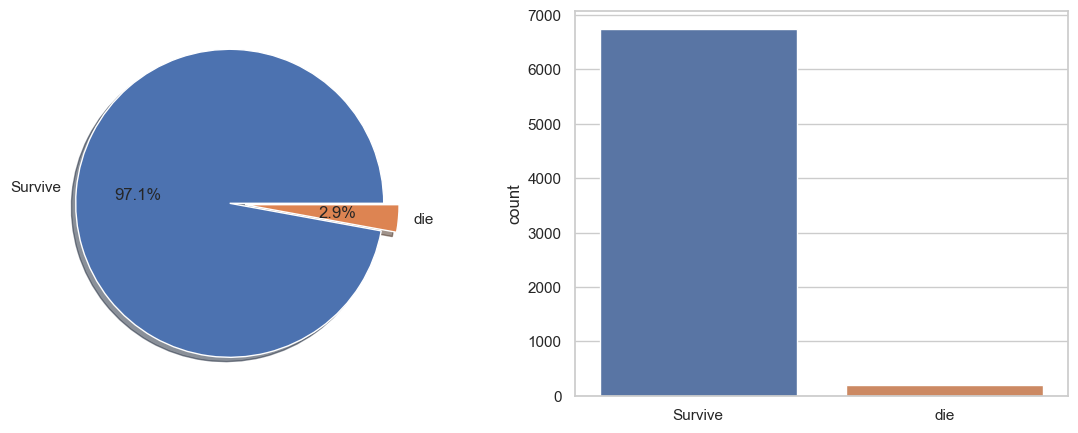

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
labels = ['Survive','die']
 
# Pie Plot
df_data['hospital_expire_flag'].value_counts().plot.pie(ax=ax[0], explode=[0,0.1], shadow=True, autopct='%1.1f%%', labels=labels)
ax[0].set(ylabel='')
 
# Count Plot
sns.countplot(data=df_data, x='hospital_expire_flag', ax=ax[1])
ax[1].set(xlabel='', xticklabels=labels)
 
plt.show()

## 나이 분포

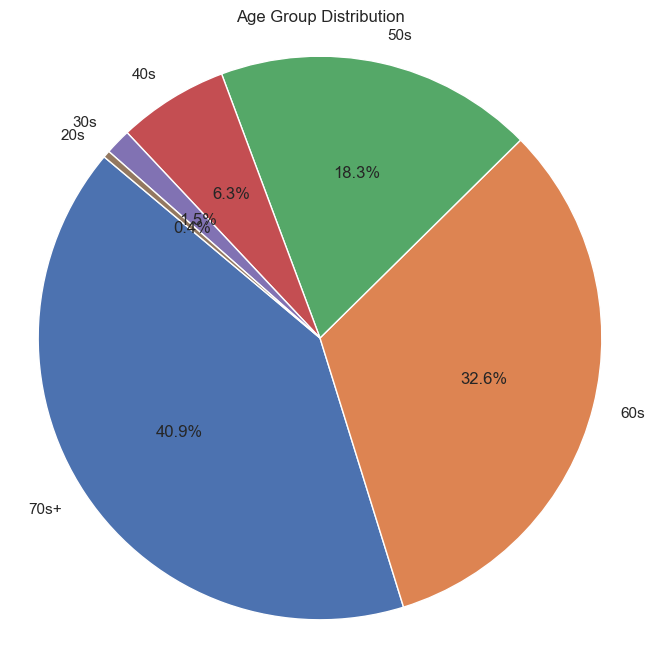

In [173]:
import matplotlib.pyplot as plt

# 나이 구간을 만들기 위한 함수
def age_group(age):
    if age < 20:
        return '10s'
    elif age < 30:
        return '20s'
    elif age < 40:
        return '30s'
    elif age < 50:
        return '40s'
    elif age < 60:
        return '50s'
    elif age < 70:
        return '60s'
    else:
        return '70s+'

# 'admit_age' 열에 적용하여 나이 구간 생성
df_data['age_group'] = df_data['admit_age'].apply(age_group)

# 각 나이 구간의 빈도 확인
age_group_counts = df_data['age_group'].value_counts()

# 파이 차트로 시각화
plt.figure(figsize=(8, 8))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Age Group Distribution')
plt.axis('equal')  # 원을 원형으로 유지
plt.show()


### 나이에 따른 사망률

C:\Users\TS\AppData\Local\Temp\ipykernel_11152\3798649685.py:6: RuntimeWarning: invalid value encountered in scalar divide
  age_range_survival_ratio.append(df_data[df_data['admit_age'] < i]['hospital_expire_flag'].sum() / len(df_data[df_data['admit_age'] < i]['hospital_expire_flag']))


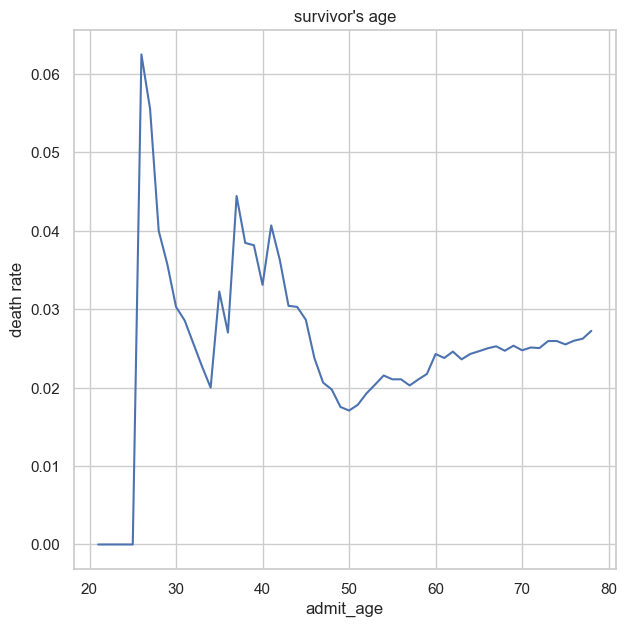

In [174]:
# 생존율을 입력받을 List 생성
age_range_survival_ratio = []
 
# 1살 부터 생존율 구하기
for i in range(1,80):
    age_range_survival_ratio.append(df_data[df_data['admit_age'] < i]['hospital_expire_flag'].sum() / len(df_data[df_data['admit_age'] < i]['hospital_expire_flag']))
 
plt.figure(figsize=(7,7))
plt.plot(age_range_survival_ratio)
plt.title('survivor\'s age')
plt.ylabel('death rate')
plt.xlabel('admit_age')
 
plt.show()

### 구간별 나이에 따른 사망률 및 유의성

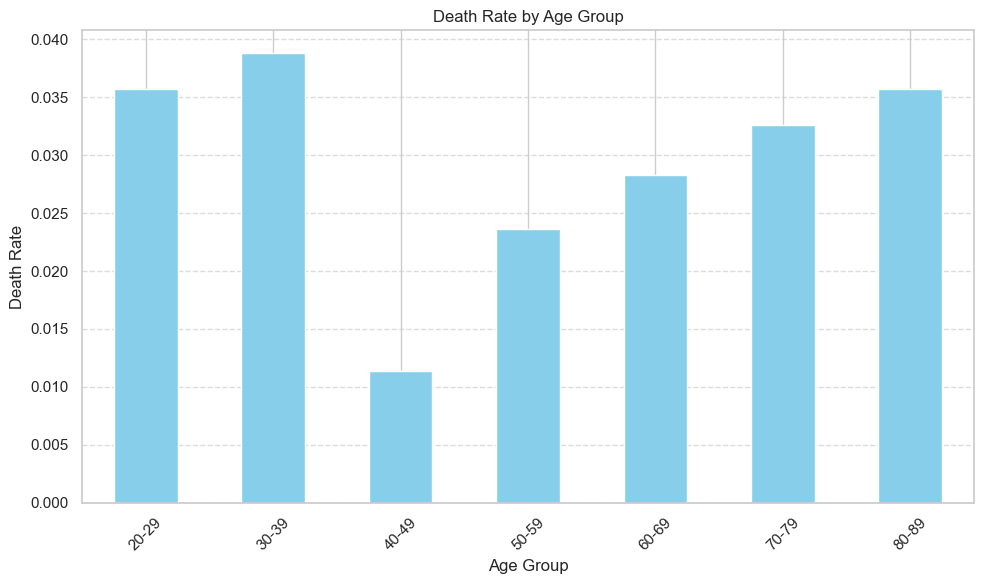

Chi-square statistic: 9.009475667753687
P-value: 0.17304586695507101
유의미한 차이가 없습니다. 귀무 가설을 채택합니다.


In [175]:
# 나이 구간 설정 (10살 간격)
age_bins = np.arange(20, 91, 10)
age_labels = [f"{i}-{i+9}" for i in age_bins[:-1]]
df_data['age_group'] = pd.cut(df_data['admit_age'], bins=age_bins, labels=age_labels, right=False)

# 각 나이 구간에 대한 사망률 계산
death_rate_by_age = df_data.groupby('age_group')['hospital_expire_flag'].mean()

# 시각화
plt.figure(figsize=(10, 6))
death_rate_by_age.plot(kind='bar', color='skyblue')
plt.title('Death Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Death Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 통계적 검정 (카이제곱 검정)
# 귀무가설: 나이 구간과 사망률은 독립적이다.
# 대립가설: 나이 구간과 사망률은 연관이 있다.

contingency_table = pd.crosstab(df_data['age_group'], df_data['hospital_expire_flag'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("유의미한 차이가 있습니다. 대립 가설을 채택합니다.")
else:
    print("유의미한 차이가 없습니다. 귀무 가설을 채택합니다.")


## 성별 분포 


['1' '0']
['F', 'M']
Categories (2, object): ['F', 'M']


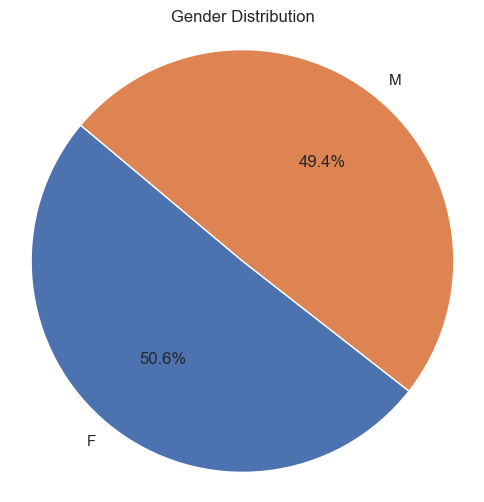

In [176]:
# hospital_expire_flag 열을 문자열로 변환
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(str)

# 유니크 값 확인
print(df_data['hospital_expire_flag'].unique())
print(df_data['gender'].unique())

# 성별 분포 파이 차트 그리기
gender_counts = df_data['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.axis('equal')  # 원을 원형으로 유지
plt.show()


### 성별에 따른 사망자수

In [177]:
df_data

,subject_id,valuenum_Sodium,valuenum_Potassium,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic,age_group
0,10002155,144.0,4.101562,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263,80-89
1,10002348,141.0,5.000000,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000,70-79
2,10005348,142.0,4.101562,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000,70-79
3,10006029,141.0,5.000000,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744,70-79
4,10006431,142.0,4.101562,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947,60-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,19992507,139.0,3.599609,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271,60-69
6937,19994588,142.0,4.199219,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588,70-79
6938,19995127,143.0,4.601562,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538,80-89
6939,19999287,139.0,4.500000,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556,70-79


In [178]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 6940
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   subject_id            6941 non-null   int64   
 1   valuenum_Sodium       6941 non-null   float16 
 2   valuenum_Potassium    6941 non-null   float16 
 3   hadm_id               6941 non-null   int32   
 4   admit_age             6941 non-null   uint8   
 5   gender                6941 non-null   category
 6   language              6941 non-null   category
 7   marital_status        6886 non-null   category
 8   race                  6941 non-null   category
 9   hospital_expire_flag  6941 non-null   object  
 10  BMI (kg/m2)           6941 non-null   float64 
 11  Height (Inches)       6941 non-null   float64 
 12  Weight (Lbs)          6941 non-null   float64 
 13  Systolic              6941 non-null   float64 
 14  Diastolic             6941 non-null   float64 
 15  age_

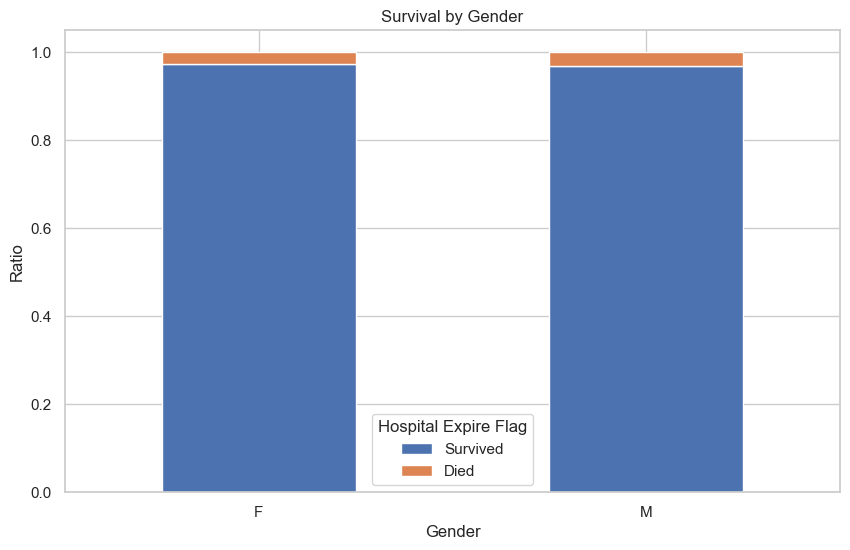

In [196]:
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(int)

# 성별에 따른 생존 여부 그룹화
gender_survival = df_data.groupby(['gender', 'hospital_expire_flag']).size().unstack()

# 성별에 따른 생존 여부 비율 계산
gender_survival['Survived_ratio'] = gender_survival[0] / (gender_survival[0] + gender_survival[1])
gender_survival['Died_ratio'] = gender_survival[1] / (gender_survival[0] + gender_survival[1])

# 시각화
gender_survival[['Survived_ratio', 'Died_ratio']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Survival by Gender')
plt.xlabel('Gender')
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.legend(title='Hospital Expire Flag', labels=['Survived', 'Died'])
plt.show()


## BMI에 따른 사망자수


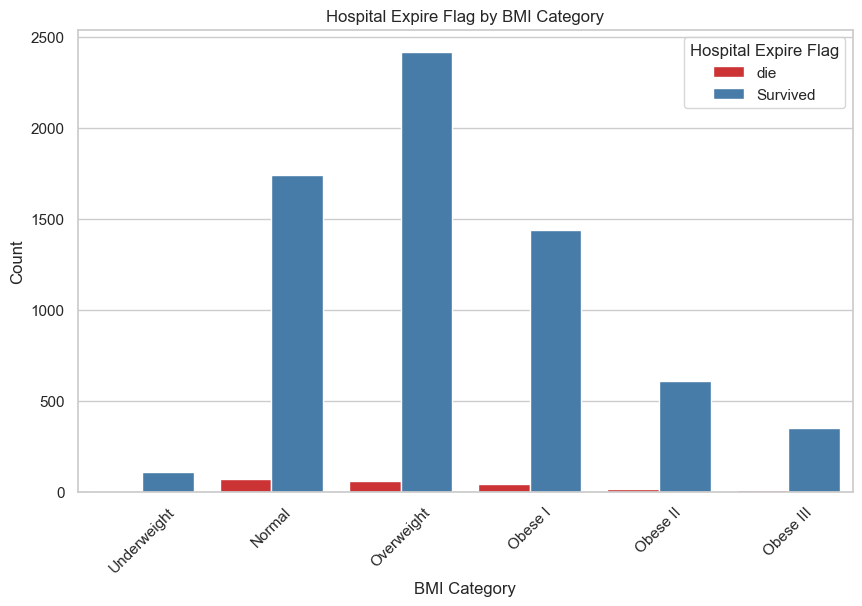

In [205]:
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(str)

# BMI 구간 나누기
bmi_bins = [0, 18.5, 25, 30, 35, 40, 50]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
df_data['bmi_category'] = pd.cut(df_data['BMI (kg/m2)'], bins=bmi_bins, labels=bmi_labels)

# BMI별 사망 비율
plt.figure(figsize=(10, 6))
sns.countplot(x='bmi_category', hue='hospital_expire_flag', data=df_data,palette='Set1')
plt.title('Hospital Expire Flag by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hospital Expire Flag', labels=['die','Survived',])
plt.show()


In [198]:
# 카테고리를 이진 숫자로 변환
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(int)

# 구간별 사망자 수 계산
bmi_death_count = df_data.groupby('bmi_category')['hospital_expire_flag'].sum()

# 구간별 총 인원 계산
bmi_total_count = df_data.groupby('bmi_category')['hospital_expire_flag'].count()

# 구간별 사망 비율 계산
bmi_death_rate = (bmi_death_count / bmi_total_count) * 100

# 결과 출력
bmi_death_rate


bmi_category
Underweight    4.424779
Normal         3.703704
Overweight     2.458686
Obese I        2.964960
Obese II       2.407705
Obese III      1.955307
Name: hospital_expire_flag, dtype: float64

### 구간별 BMI에 따른 사망률 및 유의성

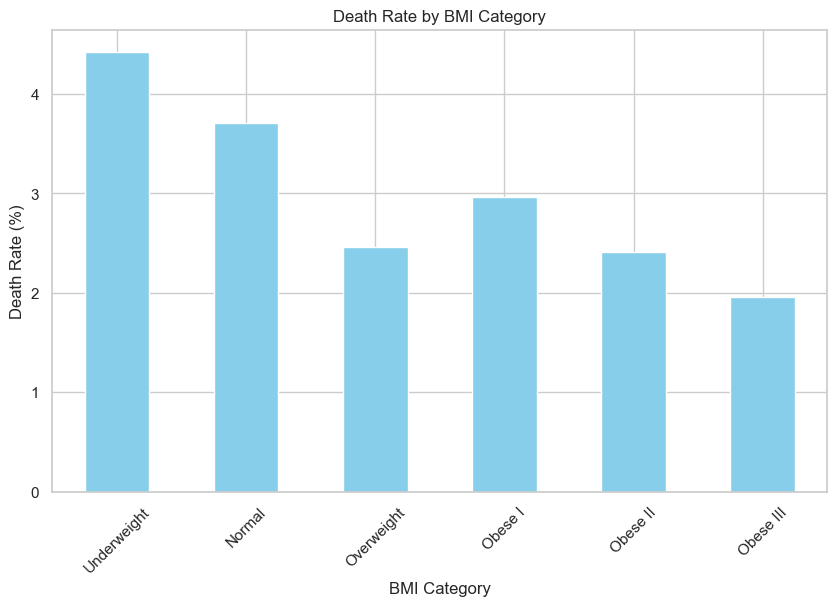

Chi-square Statistic: 8.498614817375348
p-value: 0.13081291761331104
Degrees of Freedom: 5
Expected frequencies: [[ 109.72582994    3.27417006]
 [1756.58430402   52.41569598]
 [2409.11313337   71.88686663]
 [1441.00116482   42.99883518]
 [ 604.94860221   18.05139779]
 [ 347.62696564   10.37303436]]
유의미한 차이가 없습니다. 귀무 가설을 채택합니다.


In [199]:
# 구간별 사망 비율 시각화 (바 그래프)
plt.figure(figsize=(10, 6))
bmi_death_rate.plot(kind='bar', color='skyblue')
plt.title('Death Rate by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Death Rate (%)')
plt.xticks(rotation=45)
plt.show()

# 데이터 준비
observed = pd.crosstab(df_data['bmi_category'], df_data['hospital_expire_flag'])

# 카이 제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(observed)

print("Chi-square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected frequencies:", expected)

if p < 0.05:
    print("유의미한 차이가 있습니다. 대립 가설을 채택합니다.")
else:
    print("유의미한 차이가 없습니다. 귀무 가설을 채택합니다.")


## 체내 칼륨과 나트륨농도

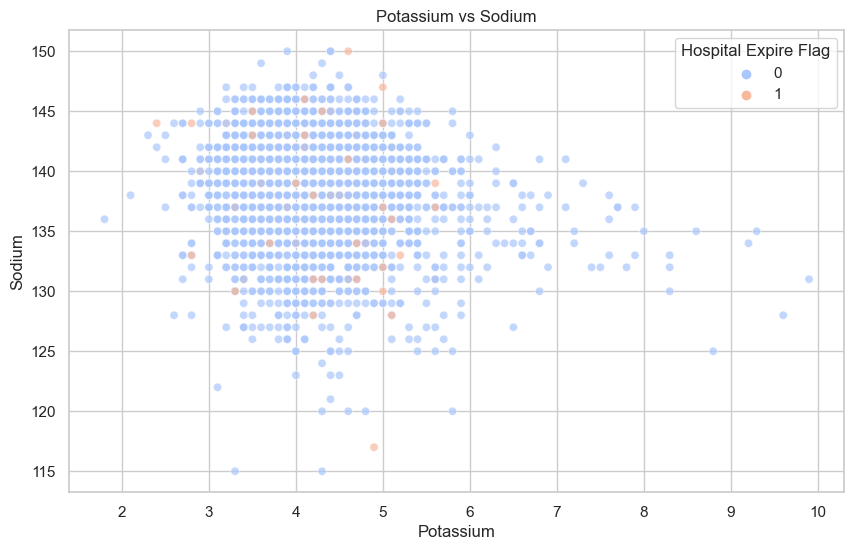

In [200]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='valuenum_Potassium', y='valuenum_Sodium', hue='hospital_expire_flag', data=df_data, palette='coolwarm', alpha=0.7)
plt.title('Potassium vs Sodium')
plt.xlabel('Potassium')
plt.ylabel('Sodium')
plt.legend(title='Hospital Expire Flag')
plt.show()


### 구간별 칼륨과 나트륨 농도 및 유의성

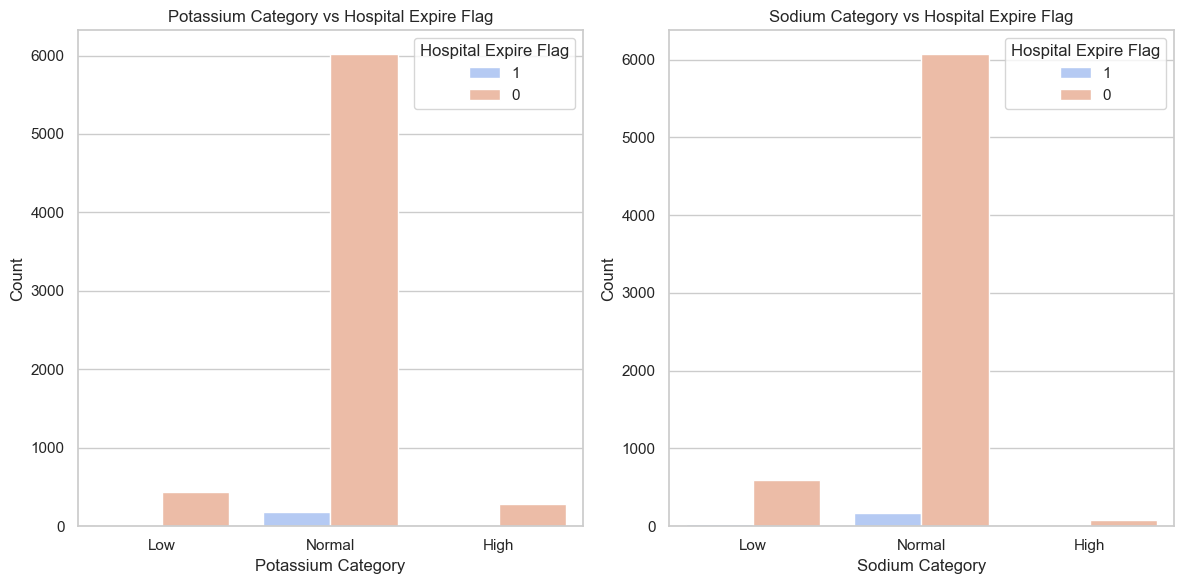

In [201]:
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(str)

# 포타슘과 소듐의 정상 범위 지정
potassium_normal_range = (3.5, 5.1)
sodium_normal_range = (135, 145)

# 정상 범위에 속하는지 여부에 따라 새로운 열 추가
df_data['potassium_category'] = np.where((df_data['valuenum_Potassium'] < potassium_normal_range[0]), 'Low',
                                         np.where((df_data['valuenum_Potassium'] > potassium_normal_range[1]), 'High', 'Normal'))
df_data['sodium_category'] = np.where((df_data['valuenum_Sodium'] < sodium_normal_range[0]), 'Low',
                                      np.where((df_data['valuenum_Sodium'] > sodium_normal_range[1]), 'High', 'Normal'))

# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='potassium_category', hue='hospital_expire_flag', data=df_data, palette='coolwarm', order=['Low', 'Normal', 'High'])
plt.title('Potassium Category vs Hospital Expire Flag')
plt.xlabel('Potassium Category')
plt.ylabel('Count')
plt.legend(title='Hospital Expire Flag')

plt.subplot(1, 2, 2)
sns.countplot(x='sodium_category', hue='hospital_expire_flag', data=df_data, palette='coolwarm', order=['Low', 'Normal', 'High'])
plt.title('Sodium Category vs Hospital Expire Flag')
plt.xlabel('Sodium Category')
plt.ylabel('Count')
plt.legend(title='Hospital Expire Flag')

plt.tight_layout()
plt.show()


In [202]:
# 포타슘 카테고리별 사망률 계산
potassium_death_count = df_data[df_data['hospital_expire_flag'] == '1'].groupby('potassium_category').size()
potassium_total_count = df_data.groupby('potassium_category').size()
potassium_death_rate = (potassium_death_count / potassium_total_count) * 100

# 소듐 카테고리별 사망률 계산
sodium_death_count = df_data[df_data['hospital_expire_flag'] == '1'].groupby('sodium_category').size()
sodium_total_count = df_data.groupby('sodium_category').size()
sodium_death_rate = (sodium_death_count / sodium_total_count) * 100

# 한글 설명
print("포타슘 카테고리별 사망률:")
print(potassium_death_rate)

print("\n소듐 카테고리별 사망률:")
print(sodium_death_rate)


포타슘 카테고리별 사망률:
potassium_category
High      2.068966
Low       3.938731
Normal    2.825315
dtype: float64

소듐 카테고리별 사망률:
sodium_category
High      3.896104
Low       4.025765
Normal    2.739068
dtype: float64


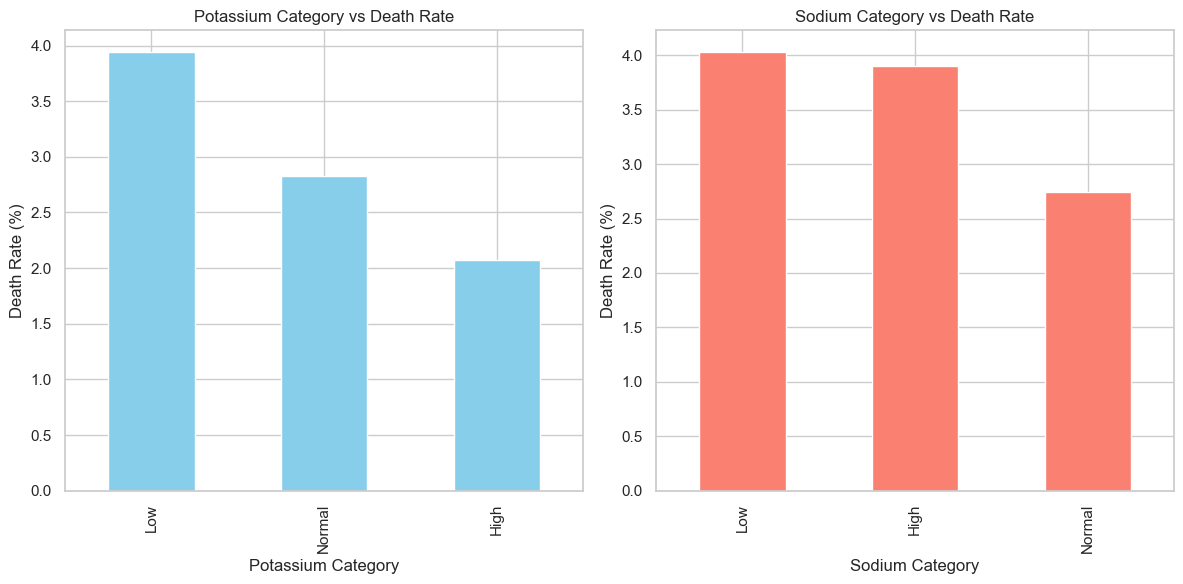

Chi-square Statistic: 2.1857776582874044
p-value: 0.33524662327060156
Degrees of Freedom: 2
Expected frequencies: [[  4.5  21.5 173. ]
 [  4.5  21.5 173. ]]
유의미한 차이가 없습니다. 귀무 가설을 채택합니다.


In [203]:
# 그래프 설정
plt.figure(figsize=(12, 6))

# 포타슘 카테고리별 사망률 시각화
plt.subplot(1, 2, 1)
potassium_death_rate.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Potassium Category vs Death Rate')
plt.xlabel('Potassium Category')
plt.ylabel('Death Rate (%)')

# 소듐 카테고리별 사망률 시각화
plt.subplot(1, 2, 2)
sodium_death_rate.sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Sodium Category vs Death Rate')
plt.xlabel('Sodium Category')
plt.ylabel('Death Rate (%)')

plt.tight_layout()
plt.show()

# 데이터 준비
observed = [[potassium_death_count[0], potassium_death_count[1], potassium_death_count[2]],
            [sodium_death_count[0], sodium_death_count[1], sodium_death_count[2]]]

# 카이 제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(observed)

print("Chi-square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected frequencies:", expected)

if p < 0.05:
    print("유의미한 차이가 있습니다. 대립 가설을 채택합니다.")
else:
    print("유의미한 차이가 없습니다. 귀무 가설을 채택합니다.")


## 혈압분포

### 수축기와 이완기에 따른 사망자 분포

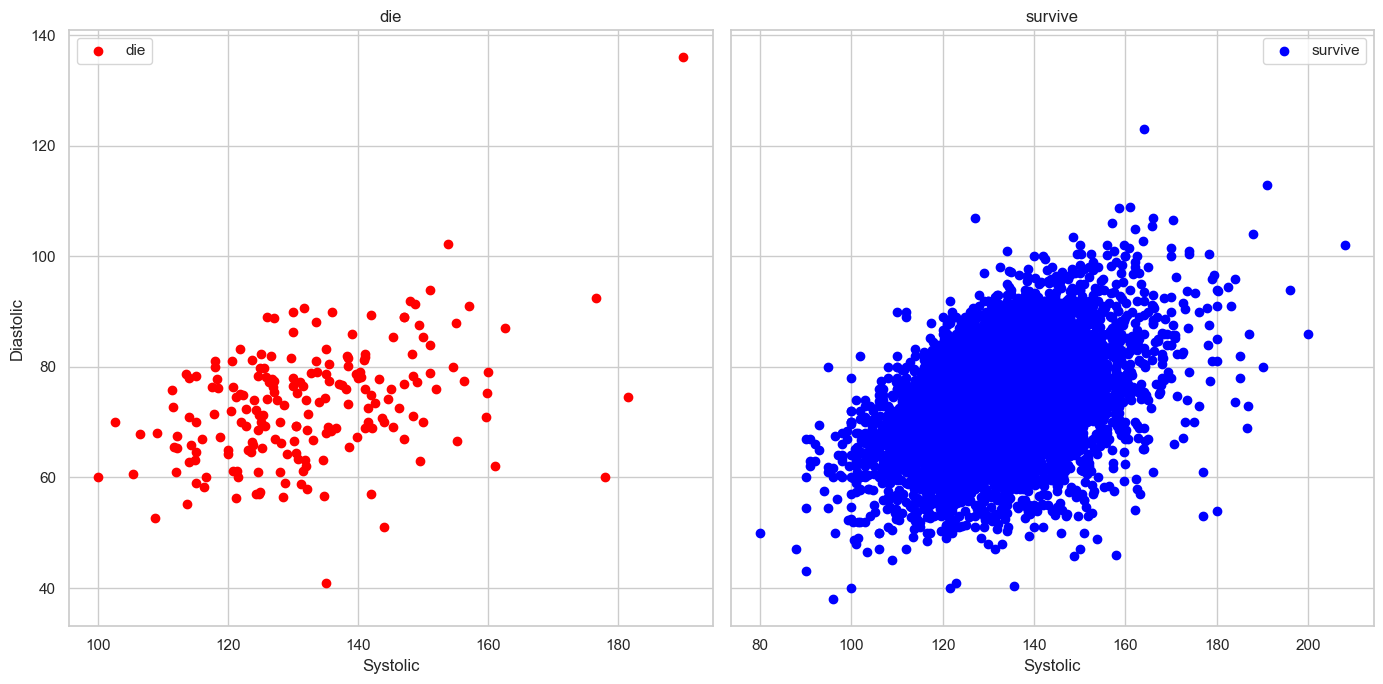

In [204]:
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(int)

# hospital_expire_flag에 따라 데이터를 나눔
df_data_expired = df_data[df_data['hospital_expire_flag'] == 1]
df_data_not_expired = df_data[df_data['hospital_expire_flag'] == 0]

# 플롯 사이즈 설정
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# hospital_expire_flag가 1인 경우
axes[0].scatter(df_data_expired['Systolic'], df_data_expired['Diastolic'], color='red', label='die')
axes[0].set_title('die')
axes[0].set_xlabel('Systolic')
axes[0].set_ylabel('Diastolic')
axes[0].legend()

# hospital_expire_flag가 0인 경우
axes[1].scatter(df_data_not_expired['Systolic'], df_data_not_expired['Diastolic'], color='blue', label='survive')
axes[1].set_title('survive')
axes[1].set_xlabel('Systolic')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()


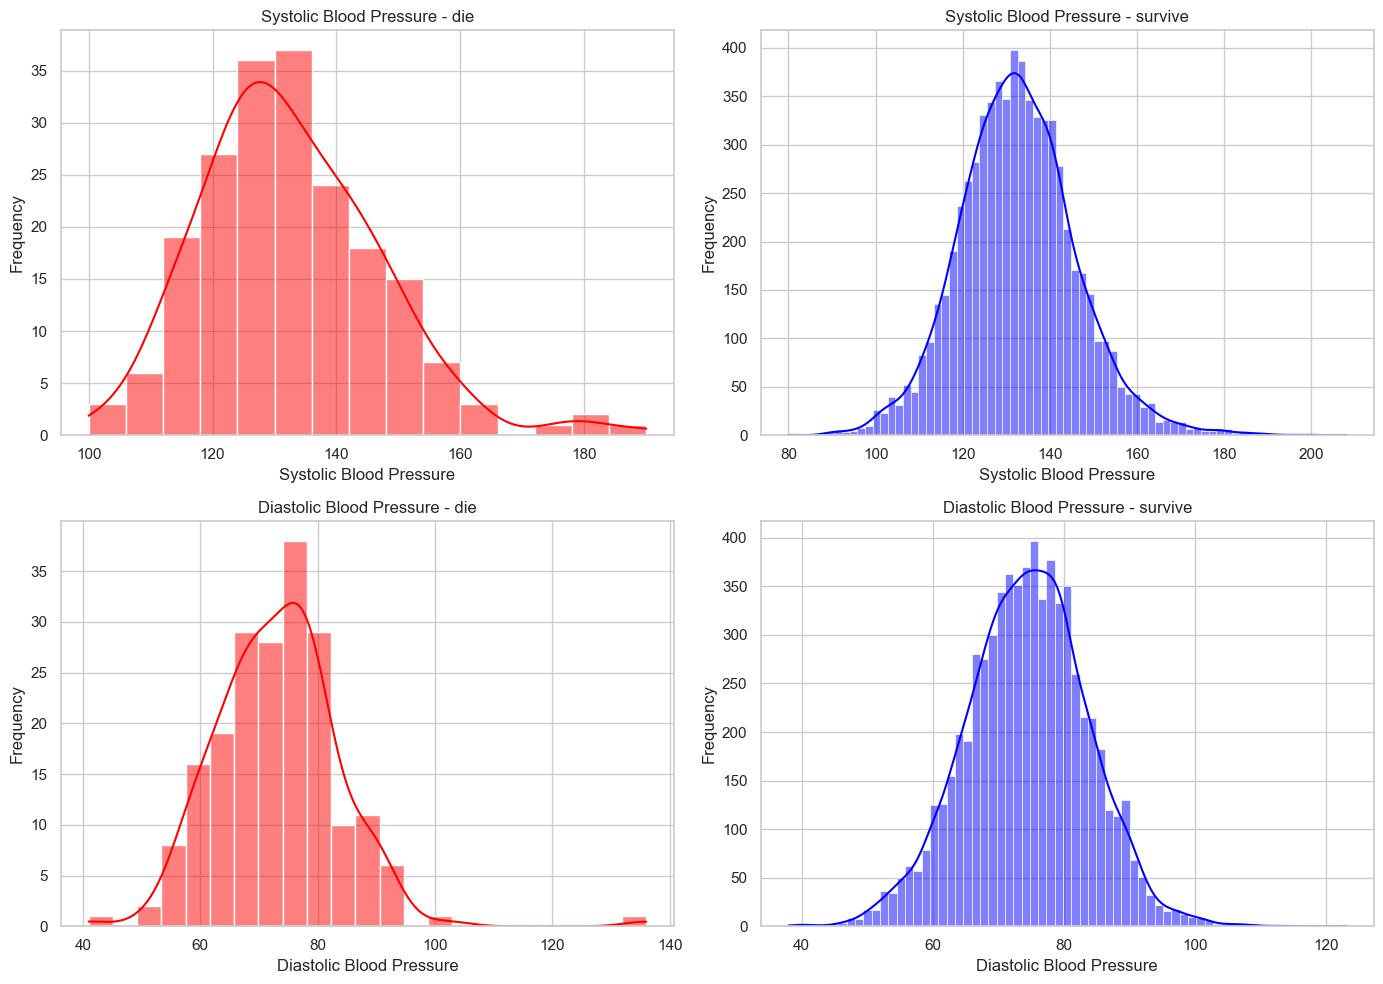

In [189]:
# 데이터를 병원 사망 여부에 따라 나눕니다
df_data_expired = df_data[df_data['hospital_expire_flag'] == 1]
df_data_not_expired = df_data[df_data['hospital_expire_flag'] == 0]

# 그래프 크기 설정
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Systolic 혈압 분포
sns.histplot(df_data_expired['Systolic'], kde=True, color='red', ax=axes[0, 0], label='Expired')
axes[0, 0].set_title('Systolic Blood Pressure - die')
axes[0, 0].set_xlabel('Systolic Blood Pressure')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df_data_not_expired['Systolic'], kde=True, color='blue', ax=axes[0, 1], label='Not Expired')
axes[0, 1].set_title('Systolic Blood Pressure - survive')
axes[0, 1].set_xlabel('Systolic Blood Pressure')
axes[0, 1].set_ylabel('Frequency')

# Diastolic 혈압 분포
sns.histplot(df_data_expired['Diastolic'], kde=True, color='red', ax=axes[1, 0], label='die')
axes[1, 0].set_title('Diastolic Blood Pressure - die')
axes[1, 0].set_xlabel('Diastolic Blood Pressure')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df_data_not_expired['Diastolic'], kde=True, color='blue', ax=axes[1, 1], label='survive')
axes[1, 1].set_title('Diastolic Blood Pressure - survive')
axes[1, 1].set_xlabel('Diastolic Blood Pressure')
axes[1, 1].set_ylabel('Frequency')

# 그래프 표시
plt.tight_layout()
plt.show()

각 수축기 혈압 그룹별 사망률:


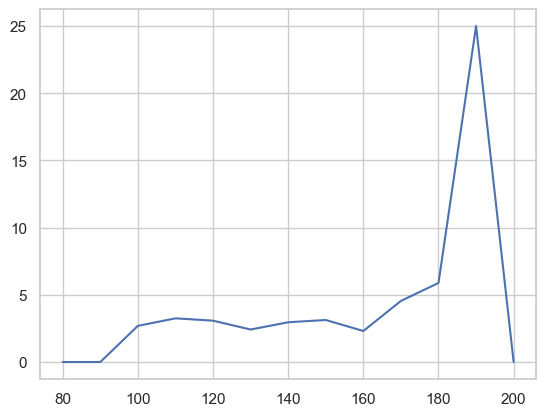

In [190]:
# 수축기 혈압을 10 단위로 그룹화
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(int)
df_data['Systolic_group'] = (df_data['Systolic'] // 10) * 10

# 각 그룹별 사망률 계산
mortality_rates = df_data.groupby('Systolic_group')['hospital_expire_flag'].mean() * 100

# 결과 출력
print("각 수축기 혈압 그룹별 사망률:")
plt.plot(mortality_rates)

### 구간별 혈압분포에 따른 사망률 및 유의성

In [191]:
# 데이터 준비
observed = pd.crosstab(df_data['Systolic_group'], df_data['hospital_expire_flag'])

# 카이 제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(observed)

print("Chi-square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected frequencies:", expected)

if p < 0.05:
    print("유의미한 차이가 있습니다. 대립 가설을 채택합니다.")
else:
    print("유의미한 차이가 없습니다. 귀무 가설을 채택합니다.")


Chi-square Statistic: 11.709454836947057
p-value: 0.4692868118705781
Degrees of Freedom: 12
Expected frequencies: [[1.94265956e+00 5.73404409e-02]
 [3.30252125e+01 9.74787495e-01]
 [2.16606541e+02 6.39345916e+00]
 [8.07175047e+02 2.38249532e+01]
 [1.83192796e+03 5.40720357e+01]
 [2.00968131e+03 5.93186861e+01]
 [1.21513355e+03 3.58664458e+01]
 [4.35155741e+02 1.28442588e+01]
 [1.26272871e+02 3.72712866e+00]
 [4.27385103e+01 1.26148970e+00]
 [1.65126063e+01 4.87393747e-01]
 [3.88531912e+00 1.14680882e-01]
 [1.94265956e+00 5.73404409e-02]]
유의미한 차이가 없습니다. 귀무 가설을 채택합니다.


## 변수간 상관관계



In [192]:
df_data.drop(['Systolic_group'],axis=1,inplace =True)

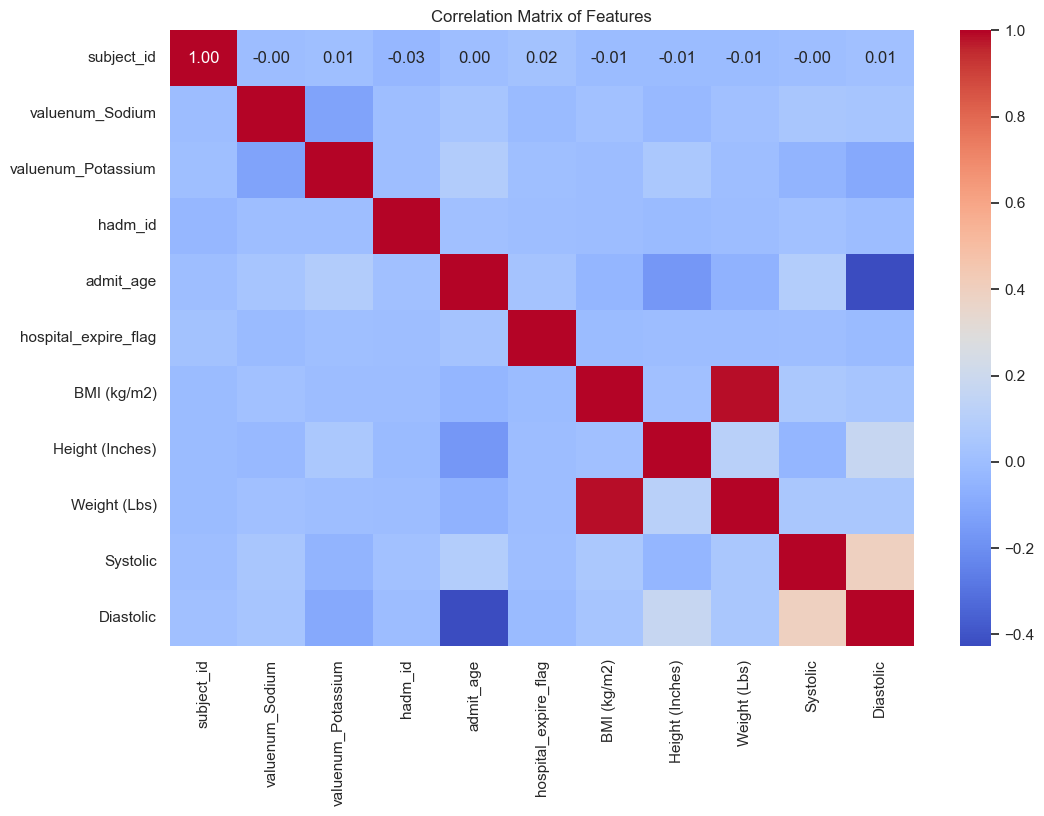

In [193]:
plt.figure(figsize=(12, 8))
corr_matrix = df_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()